# import libraries and defining utility functions

In [449]:
import albumentations as A
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, dump, ElementTree
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import cv2
import os
from pascal_voc_writer import Writer
from xml.dom import minidom
import imgaug as ia
import imgaug.augmenters as iaa
import math
import random
import copy
import glob
import os
random.seed(7)

def writeVoc(bboxes, count, image):
    height, width, channels = image.shape
    imagepath = 'C:/Users/max_x/Desktop/all/'+str(count)+'.jpg'
    xmlpath = 'C:/Users/max_x/Desktop/all/'+str(count)+'.xml'
    writer = Writer(imagepath, width, height)

    for i in bboxes:
        writer.addObject(i[4], int(i[0]), int(i[1]), int(i[2]), int(i[3]))
    writer.save(xmlpath)

# 이미지 보여주는 함수
def imshow(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# VOC 포맷의 xml 읽고 파싱하여 bboxes의 크기와 좌표값을 나타내는 리스트로 변환    
def from_xml(filepath):    
    doc = ET.parse(filepath)
    root = doc.getroot()
    lst = []
    object_tag = root.findall('object')
    for i in range(6):
        objannot = [int(object_tag[i].find('bndbox').findtext('xmin')), 
                   int(object_tag[i].find('bndbox').findtext('ymin')),
                   int(object_tag[i].find('bndbox').findtext('xmax')), 
                   int(object_tag[i].find('bndbox').findtext('ymax')),
                   object_tag[i].find('name').text]
        lst.append(objannot)
    return lst


BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

# bounding box가 포함된 이미지를 반환
def visualize_bbox(img, bbox, color = BOX_COLOR, thickness = 2, **kwargs):
    x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    cv2.rectangle(img, (x_min, y_min),(x_max, y_max),color = color, thickness = thickness)
    return img    


# 클래스의 이름이 포함된 이미지를 반환
def visualize_titles(img, bbox, title, color = BOX_COLOR, thickness = 2, font_thickness = 2, font_scale=0.35, **kwargs):
    x_min, y_min, x_max, y_max = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img

# 좌측에 원본이미지, 우측에 증강된 이미지를 보여주는 함수
def augment_and_show(aug, image, mask = None, bboxes=[], categories = [], category_id_to_name = [],
                    filename = None, font_scale_orig = 0.35, font_scale_aug = 0.35, show_title = True, **kwargs):
    augmented = aug(image = image, bboxes = bboxes, category_id = categories)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes :
        visualize_bbox(image, bbox, **kwargs)
        
    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)
        
    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

            
    f, ax = plt.subplots(1, 2, figsize=(16, 8))

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(image_aug)
    ax[1].set_title('Augmented image')

    f.tight_layout()

    if filename is not None:
        f.savefig(filename)
    return augmented['image'], augmented['bboxes']

# 이미지를 출력하지는 않지만 증강작업을 수행하는 함수
def augment_and_return(aug, image, mask = None, bboxes=[], categories = [], category_id_to_name = [],
                    filename = None, font_scale_orig = 0.35, font_scale_aug = 0.35, show_title = True, **kwargs):
    augmented = aug(image = image, bboxes = bboxes, category_id = categories)
    plt.imshow(augmented['image'])
    return augmented['image'], augmented['bboxes']

# 증강된 이미지와 라벨을 지정된 위치에 저장
def augment_and_save(saving_path, raw_path, Augmentation_multiple):
    xml_list = []
    for name in os.listdir(raw_path):
        if name.endswith('xml') :
            xml_list.append(name)
    images_list = []
    for name in os.listdir(raw_path):
        if name.endswith('jpg') :
            images_list.append(name)
        
    xml_list.sort()
    images_list.sort()

    for k in range(Augmentation_multiple) :
        for i in range(len(xml_list)) : 
            label = from_xml(raw_path + '/'+ xml_list[i])
            images = cv2.imread(raw_path + '/' + images_list[i])
            aug_img , aug_bbox = augment_and_return(Augmen1, image, bboxes = label)
            cv2.imwrite(os.path.join(saving_path, images_list[i].split('.')[0]+'-'+str((k+1))+'.jpg'), aug_img)
            
            
            targetXML = open(os.path.join(raw_path, xml_list[i]), 'rt', encoding='UTF8')
            tree = ET.parse(targetXML)
            root = tree.getroot()
            object_tag = root.findall('object')
            for j in range(len(aug_bbox)):
                object_tag[j].find('name').text = aug_bbox[j][4]
                object_tag[j].find('bndbox').find('xmin').text = str(aug_bbox[j][0])
                object_tag[j].find('bndbox').find('ymin').text = str(aug_bbox[j][1])
                object_tag[j].find('bndbox').find('xmax').text = str(aug_bbox[j][2])
                object_tag[j].find('bndbox').find('ymax').text = str(aug_bbox[j][3])
            for w in range(len(aug_bbox),len(root.findall('object'))):
                root.remove(root.findall('object')[len(aug_bbox)])
            tree.write(os.path.join(saving_path, xml_list[i].split('.')[0]+'-'+str((k+1))))
            
            
            if i % 20 == 1 :            
                print(i,'Augmented Images has been saved')
        print(k+1,'sets of augmented dataset has been generated')       

# Defining Augmentation Pipeline

In [450]:
Augmen1 = A.Compose([
    A.Equalize(p = 0.5),
    A.RandomResizedCrop(p = 0.7, height = 400, width = 600, scale = (0.1, 1.0), ratio = (0.75,1)),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.75),
    A.RandomFog(p = 0.25, fog_coef_lower = 0.1, fog_coef_upper = 0.3),
    A.MultiplicativeNoise(multiplier=(1, 1.2), per_channel=False,  elementwise=False, 
        always_apply=False, p=0.2 ),
    #A.VerticalFlip(),
    #A.HorizontalFlip()
],A.BboxParams(format = 'pascal_voc', min_visibility = 0.4))

# Select the path and augment

In [451]:
saving_path = os.path.join(os.getcwd(),'Augmented_data')
raw_path = os.path.join(os.getcwd(),'data', 'coco_thick2_background','xml')

1 st image has been augmented
21 st image has been augmented
41 st image has been augmented
61 st image has been augmented
81 st image has been augmented
101 st image has been augmented
Augmentation 1 has been completed


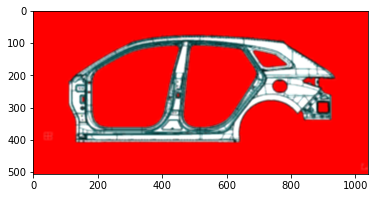

In [448]:
augment_and_save(saving_path, raw_path,1)

In [312]:
object_tag

[<Element 'object' at 0x7fe749d41130>,
 <Element 'object' at 0x7fe749d414a0>,
 <Element 'object' at 0x7fe76b34a090>,
 <Element 'object' at 0x7fe76b34b130>,
 <Element 'object' at 0x7fe7628555e0>,
 <Element 'object' at 0x7fe762855900>]

In [334]:
object_tag[3].clear

<function Element.clear()>

In [335]:
object_tag

[<Element 'object' at 0x7fe749d41130>,
 <Element 'object' at 0x7fe749d414a0>,
 <Element 'object' at 0x7fe76b34a090>,
 <Element 'object' at 0x7fe76b34b130>,
 <Element 'object' at 0x7fe7628555e0>,
 <Element 'object' at 0x7fe762855900>]

In [336]:
object_tag[3].find('bndbox').find('xmin').text

'833'

In [337]:
root.remove(object_tag[3])

ValueError: list.remove(x): x not in list

In [338]:
object_tag[3].find('bndbox').find('xmin').text

'833'

In [339]:
root

<Element 'annotation' at 0x7fe753c337c0>

In [398]:
targetXML

<_io.TextIOWrapper name='/Users/jaewoo/Co-op/data/coco_thick2_background/xml/2_103.xml' mode='rt' encoding='UTF8'>

In [399]:
tree = ET.parse(targetXML)

In [400]:
root.findall('object')

[<Element 'object' at 0x7fe762887130>, <Element 'object' at 0x7fe762887450>]

In [403]:
root.findall('object')[0]

<Element 'object' at 0x7fe762887130>

In [374]:
for w in range(4,6):
    root.remove(root.findall('object')[w])

IndexError: list index out of range

In [406]:
targetXML = open(os.path.join(raw_path, xml_list[0]), 'rt', encoding='UTF8')

In [407]:
targetXML

<_io.TextIOWrapper name='/Users/jaewoo/Co-op/data/coco_thick2_background/xml/2_1.xml' mode='rt' encoding='UTF8'>

In [408]:
tree = ET.parse(targetXML)

In [409]:
root = tree.getroot()

In [411]:
len(root.findall('object'))

6

In [436]:
targetXML = open(os.path.join(raw_path, xml_list[102]), 'rt', encoding='UTF8')

In [437]:
targetXML

<_io.TextIOWrapper name='/Users/jaewoo/Co-op/data/coco_thick2_background/xml/2_99.xml' mode='rt' encoding='UTF8'>

In [438]:
tree = ET.parse(targetXML)
root = tree.getroot()

In [439]:
root.findall('object')

[<Element 'object' at 0x7fe744b37a40>,
 <Element 'object' at 0x7fe73e245a90>,
 <Element 'object' at 0x7fe73e2457c0>,
 <Element 'object' at 0x7fe73e2452c0>,
 <Element 'object' at 0x7fe765e0e950>,
 <Element 'object' at 0x7fe765e0ea90>]

In [441]:
targetXML = open(os.path.join(raw_path, xml_list[i]), 'rt', encoding='UTF8')

In [442]:
tree = ET.parse(targetXML)
root = tree.getroot()

In [444]:
root.remove(root.findall('object')[4:])

TypeError: remove() argument must be xml.etree.ElementTree.Element, not list

In [440]:
len(aug_bbox)

4